In [1]:
%load_ext autoreload
%autoreload 2

from theano.sandbox import cuda
cuda.use('gpu0')

import os, sys
from luvgg16 import VGG16
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
np.set_printoptions(precision=4, linewidth=100)

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)
/home/lukaka/anaconda2/envs/py3/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
NB_HOME = os.path.dirname(os.getcwd())
DATA_HOME = NB_HOME + '/data/redux'
MODEL_WEIGHT_PATH = DATA_HOME+'/result/vgg_model.h5'

VALID_PATH = DATA_HOME + '/validation/'
TEST_PATH = DATA_HOME + '/test/'
print(NB_HOME)
print(DATA_HOME)

/home/lukaka/Desktop/fastai-DL-course/deeplearning1/nbs
/home/lukaka/Desktop/fastai-DL-course/deeplearning1/nbs/data/redux


### load fine tuned model

In [4]:
vgg = VGG16(pretrained_weight_path=MODEL_WEIGHT_PATH)

model loaded from path=/home/lukaka/Desktop/fastai-DL-course/deeplearning1/nbs/data/redux/result/vgg_model.h5


### check on validation set prediction
> label (1 = dog, 0 = cat)

everytime you use the `flow_from_directory()` batch generator will leave side effects so the next time would be different. I used the same batch generator to evaluate accuracy, precision and recall. The more I reuse the same batch generator, the more the performance degrades.
> generate new generator each time you need to use it!

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

valid_batch = vgg.get_batch_generator(VALID_PATH, shuffle=False)
y = valid_batch.classes
filenames = valid_batch.filenames

Found 2500 images belonging to 2 classes.


***

In [6]:
y_prob = vgg.predict_prob_generator(VALID_PATH)

Found 2500 images belonging to 2 classes.


In [7]:
y_pred = vgg.predict_label_generator(y_prob)

#### precision, recall, accuracy

In [8]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.97      0.98      1247
          1       0.97      0.98      0.98      1253

avg / total       0.98      0.98      0.98      2500



In [9]:
print(accuracy_score(y, y_pred))

0.9776


#### random correct case

In [10]:
correct_args = np.where(y==y_pred)[0]
len(correct_args)

2444

In [11]:
def plot(n, args_pool, y_pred, filenames, base_path, random=True):
    """
        n: has to be a square number, 4, 9, 16....
    """
    grid_size = int(np.sqrt(n))
    
    fig, ax_array = plt.subplots(nrows=grid_size,
                                 ncols=grid_size,
                                 sharex=True, sharey=True,
                                 figsize=(9, 9))

    n_args = np.random.choice(args_pool, n, replace=False) if random else args_pool[:n]
    
    for r in range(grid_size):
        for c in range(grid_size):
            i = n_args[r*grid_size + c]
            fname = filenames[i]
            fpath = base_path + fname
            img = mpimg.imread(fpath)
            ax_array[r, c].imshow(img)
            ax_array[r, c].set_title('pred={}'.format(y_pred[i]))

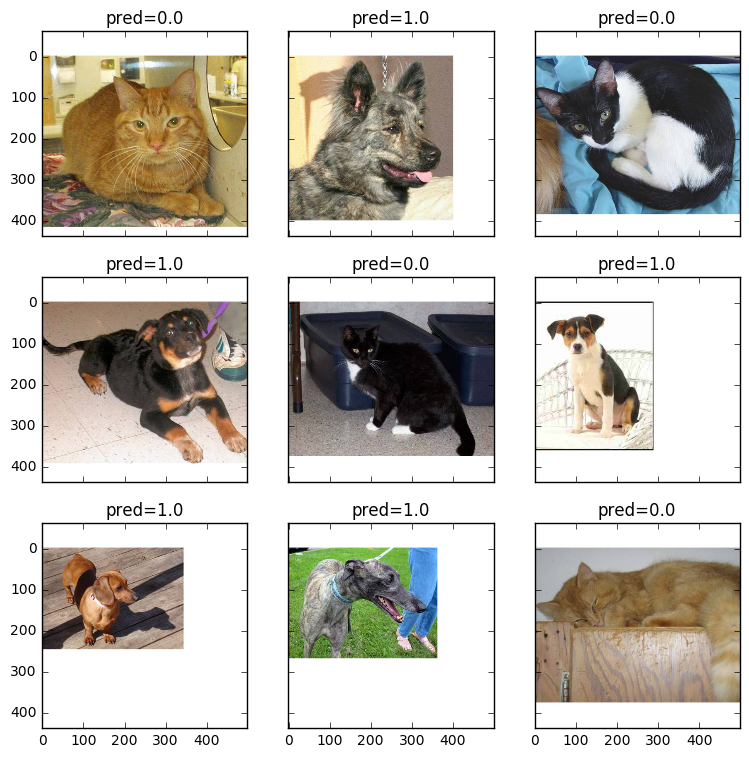

In [12]:
plot(9, correct_args, y_pred, filenames, VALID_PATH)

### incorrect cases

In [13]:
incorrect_args = np.where(y!=y_pred)[0]
len(incorrect_args)

56

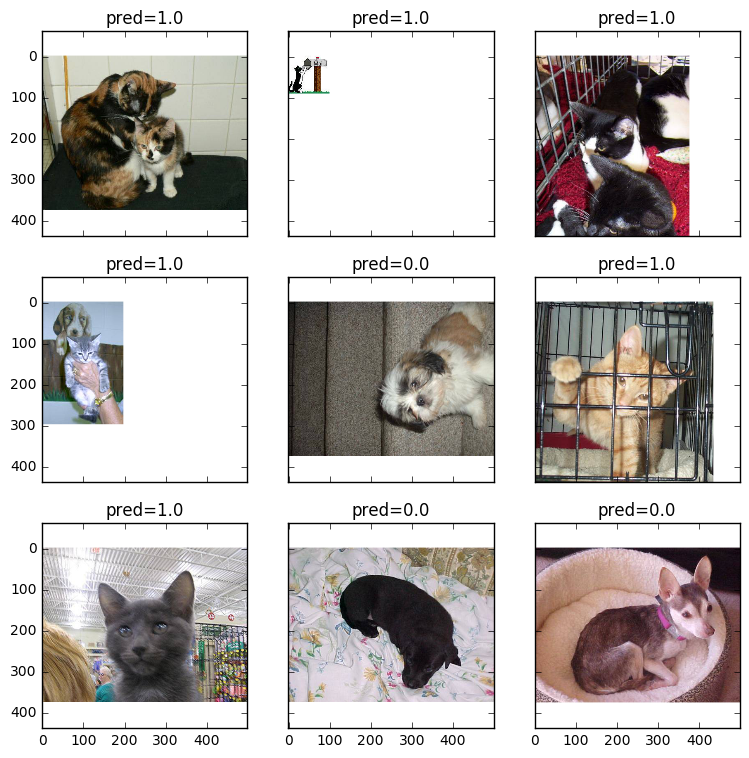

In [14]:
plot(9, incorrect_args, y_pred, filenames, VALID_PATH)

### most correct case

In [15]:
correct_cat = np.where((y==0) & (y_pred==0))[0]

In [16]:
most_confident_cat = correct_cat[np.argsort(y_prob[correct_cat])]

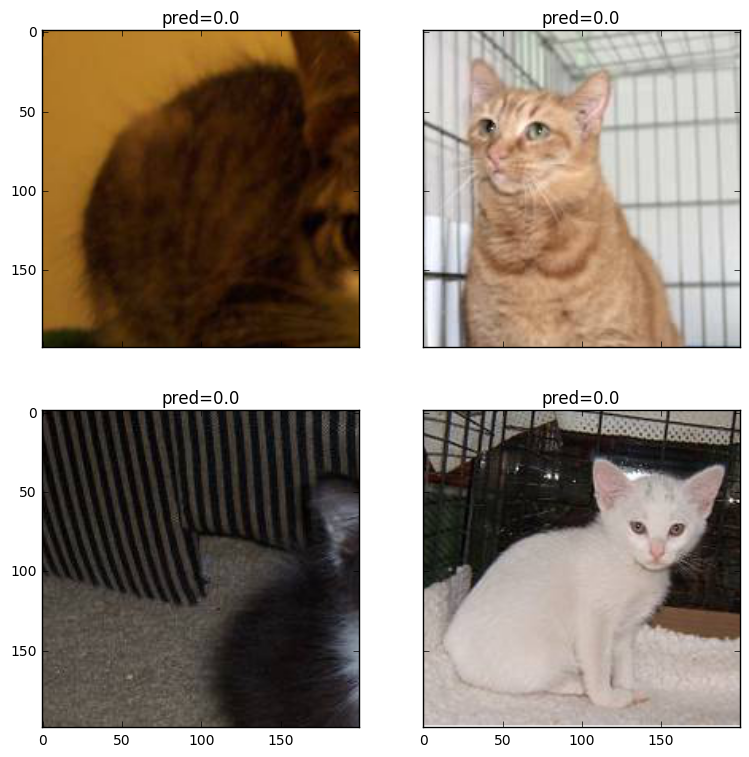

In [17]:
plot(4, most_confident_cat, y_pred, filenames, VALID_PATH, random=False)

In [18]:
correct_dog = np.where((y==1) & (y_pred==1))[0]

In [19]:
most_confident_dog = correct_dog[np.argsort(y_prob[correct_dog])[::-1]]

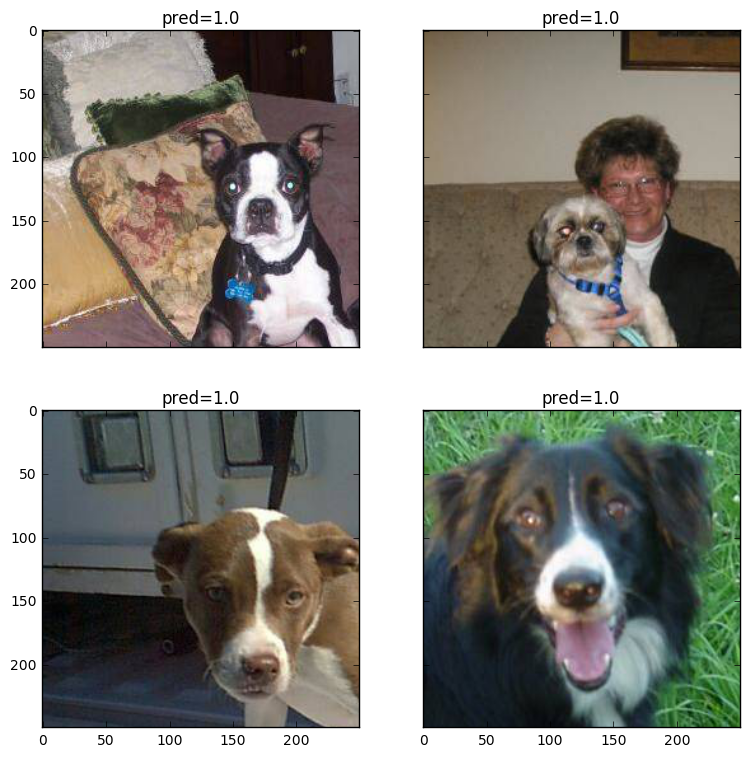

In [20]:
plot(4, most_confident_dog, y_pred, filenames, VALID_PATH, random=False)

In [21]:
confusion_matrix(y, y_pred)

array([[1213,   34],
       [  22, 1231]])